1. The use of the word '*encoder*' is different in the HF ecosystem and in this lesson. In this lesson, '*encoder*' refers to the body of the model.

2. **Exercise:** After finishing Chapter 12, re-create the `AWD_LSTM` language model from scratch, and replicate the `save_encoder` method of `TextLearner` (using pure PyTorch). Then, perform transfer learning on it (using pure PyTorch) to create a text classifier. This time, replicate the `load_encoder` method of `TextLearner`. The classifier has to be able to re-use the same vocab as the LM. But it should be possible to add tokens and resize the embedding matrix. For data prep, you can use the facilities of fast.ai for now. Don't try to train your own tokenizer at this stage. Also, the data prep for causal LM is different from the data prep for (say) sequence classification; the latter needs to maintain each sequence as a separate training example. Hence, using the data prep steps for (say) BERT isn't suitable for language modeling. Finally, the classifier needs to be able to process long sequences (of say 3,345 tokens), but be able to split each batch into shorter sequences of length 72 (say). Truncation isn't used by fastai. Hence, `AWD_LSTM` might be better than transformer-based models for longer sequences.

3. **Exercise:** Also replicate the `predict` method for both the LM and the text classifier. For the former, implement the `temperature` argument. Does it use greedy search? Read the HF blog post & chapter on text generation.

4. Apparently, the initialization of an RNN layer is the identity matrix? Check.

5. The reason we create batches in the following manner is that `AWD_LSTM` is a stateful RNN. In other words, it maintains the hidden state from one batch to another. The hidden state is reset at the end of each epoch.

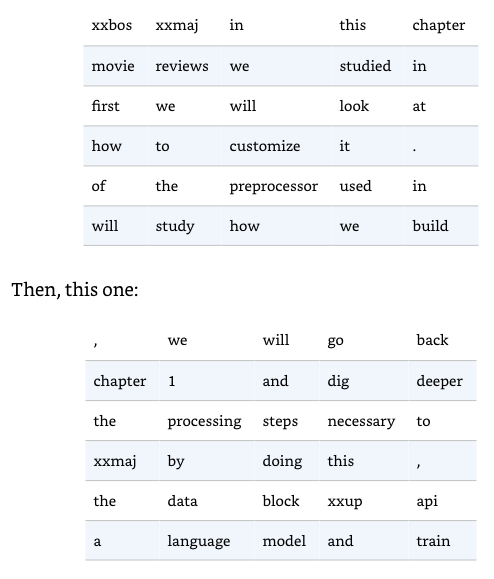

**Note:** Each row within a batch is treated as totally independent.

6. In `LMDataLoader`, the default sequence length is `72`. It can be used to create training and validation data loaders separately.

7. The `DataBlock` API is an alternative to doing tokenization, numericalization and data loader creation manually.

8. **Question:** When using SentencePiece, does `Numericalize` use the `vocab_sz` parameter of SentencePiece, or do we need to set it explicitly when instantiating `Numericalize`? If it's the former, then does it include special tokens? Or do we need to wrap it with fastai's `Tokenizer` class? Experiment to find out!

9. **Question:** In the domain adaptation step, how come we don't have to pass a vocab argument to `TextBlock.from_folder`? How will fastai know that we're trying to re-use the vocab of `AWD_LSTM`? In fact, the following text snippet seems to suggest that `AWD_LSTM`'s vocab is not re-used in the domain adaptation step.

> The reason that `TextBlock` is special is that setting up the numericalizer’s vocab can take a long time (we have to read and tokenize every document to get the vocab).

It's also mentioned in the book that:

> The reason that we pass the vocab of the language model is to make sure we use the same correspondence of token to index. Otherwise, the embeddings we learned in our fine-tuned language model won’t make any sense to this model, and the fine-tuning step won’t be of any use.

**Answer:** The following text from the book provides a hint:

> ... the embeddings in the pretrained model are merged with random embeddings added for words that weren’t in the pretraining vocabulary.

So what's happening is probably the following: In the domain adaptation data loaders creation step, new tokens are being added. But old tokens (from Wikitext103) aren't being subtracted. And the input ID of each token is also taken from the `Numericalize` object used to train `AWD_LSTM` on Wikitext103. (This probably happens when you pass `is_lm=True` in the call to `TextBlock.from_folder`.) New tokens discovered during the domain adaptation step are added to the end of the vocab by the new version of `Numericalize`?

10. **Question:**

> This will train only the embeddings (the only part of the model that contains randomly initialized weights — i.e., embeddings for words that are in our IMDb vocab, but aren’t in the pretrained model vocab).

Isn't `requires_grad` set at a tensor level? Is it possible to keep the embedding vectors of the new tokens unfrozen?

11. **Exercise:** Master the material in (i) the "NLP From Scratch" PyTorch tutorials, (ii) Andrej Karpathy's blog post on the unreasonable effectiveness of RNNs, (iii) Aurelien's Udacity RNN chapter, (iv) Aurelien's RNN book chapters. Also revise Chapter 8 properly to understand embeddings properly, and to revise the recsys architectures.

12. **Exercise:** Train your own transformer model (something like GPT2) on the human numbers dataset, and then on Wikitext103.

13. **Exercise:** Train 2 seq2seq models from scratch (one RNN and one T5-like Transformer) with a translated version of the human numbers dataset.

14. **Note:** Thanks to an inner state, a stateful RNN is able to do a good job at producing the same activations (for each token), regardless of the sequence length we pick for our batches. But it's not able to do a perfect job at this because of the way in which we cut the original concatenated stream of 50,000 tokens into 10 mini streams of 5,000 tokens each (which are treated as independent). One way to overcome this is to use a batch size of 1 (like Aurelien showed). But that has it's downsides, in particular slower convergence.

15. **Question:** The training for the domain adaptation step is drastically slower than the text classifier fine-tuning step. Why is this? The architectures are the same except for the final layer.

16. **Question:** This is in regard to the classification fine-tuning step. If multiple sequences are formed from one review (by splitting the review into sequences), then what does a batch of features & labels look like? It seems that truncation isn't being used by fastai. `x_batch` has shape `torch.Size([128, 3345])`. What's going on? Jeremy mentions in the video that we're splitting each movie review into sequences based on the `seq_len=72` argument.

Here's what I think is happening (post tokenization & numericalization):

First, we approximately sort the movie reviews so that reviews of similar length are collated together. Next, we pad the numericalized reviews. Now, remember that in the language modeling step, we split the single big batch tensor into multiple tensors (each with a shorter sequence length). Here, we do the same for `x` tensor in the classification data loader. Only after all the tensors (within a particular batch) are passed through the stateful RNN are the final output and loss calculated (by comparing the logits to the labels)?

Revisit this point after studying Chapter 12.

17. **Question:** How does `AWD_LSTM` know how to ignore the `"xxpad"` token without being passed an `'attention_mask'` tensor?

> We will expand the shortest texts to make them all the same size. To do this, we use a special padding token that will be ignored by our model.

**Possible answer:** Maybe the labels associated with the `"xxpad"` token are being set to `-100`, which is ignored by `nn.CrossEntropyLoss`.

18. **Exercise:** Implement gradual unfreezing and discriminative learning rates in pure PyTorch. In the process, figure out how `slice` is being used in fastai.

19. After finishing Chapter 11, do the domain adaptation (of `AWD_LSTM` pre-trained weights) & text classification steps without the DataBlock API & without fastai's `Learner`. In other words, feel free to use fastai's mid-level API & pure PyTorch. Feel free to use fastai's tokenizers, numericalizer & classes like `LMDataLoader`. And this time, use WANDB tracking, and push both models to the HF Hub. If successful, repeat this with the `AWD_LSTM` backwards model.

---

20. Creating simple datasets (like the '*human numbers*' dataset) for the purpose of prototyping various models (quickly trying new ideas out) & debugging a new model is an under-utilized, under-appreciated technique. Very few people do it.

21. The following line is called '*truncated BPTT*':

```
self.h = self.h.detach()
```

By using `self.h`, we're maintaining the hidden state across batches, but we're not adding the hidden state computations in `forward` to the DAG across multiple batches. We are, however, adding the input embedding, hidden state & final linear layer computations in `forward` to the DAG within a single batch. Note that the `self.h.detach()` call happens after the output `out` is computed. So the chain rule should still work for the earlier layers `self.h_h` and `self.i_h`.

**Note:** This is the second simplifying assumption made while implementing stateful RNNs. The first is that the rows within a batch are totally independent. Both the assumptions are made keeping pragmatism in mind.

22. The "**Creating More Signal**" subsection makes the transition from sequence-to-vector RNNs (which have output shape `(bs, vocab_sz`) to sequence-to-sequence RNNs (which have output shape `(bs, seq_len, vocab_sz)`). In sequence-to-sequence RNNs, there is an output associated with each token. As we process each token (i.e., go through each time step), the output (NOT JUST the hidden state) for that particular token gets computed.

```
outs.append(self.h_o(self.h))
```

The output is stored (in `outs`), whereas the hidden state is used to update the hidden state for the next token. And so on...

The hidden state is linked across tokens. It gets updated as we process each token (just like in sequence-to-vector RNNs).

23. In the lesson video, a student remarked that an RNN layer is initialized using the identity matrix. Jeremy agreed that this is one quite popular approach to initializing the linear layer inside an RNN cell. This ensures that you start with something that doesn't have activation explosions or gradient explosions.

However, in the <a href="https://pytorch.org/docs/stable/generated/torch.nn.RNNCell.html" target="_blank">documentation</a> of `nn.RNNCell`, it's mentioned that:

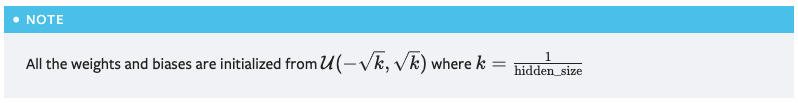

Which one is better?

24. With your own custom RNN (or `nn.RNNCell` / `nn.LSTMCell`), it's easy to check whether the activations are exploding. At each time step, you can print them out, or print out their stats, or store the stats for visualizing later. fastai also provides a class called `ActivationStats` that you can use to visualize the activation stats.

25. **Exercise:** Use custom `Dropout`, custom AR & custom TAR in your pure PyTorch version of the '*12_nlp_dive.ipynb*' notebook.

26. Suggestions for next steps:

- Go back to Lesson 1. But do things from scratch yourself (e.g., in pure PyTorch). Go deeper into the assignments.
- Pick a Kaggle competition to enter.
- Pick a book that you want to read about deep learning.
- Read an academic paper. (You can team up with others to do a paper reading group.)
- Engage with others on the fast.ai forum. You might find some projects that are going on that look interesting.
- Write blog posts. Try to write on things in your area of expertise / projects at work / a hobby. Be sure to share it on the forum.